In [1]:
import os
import sys
import csv 
import argparse
import glob
import time 

from datetime import datetime
import numpy as np
import pandas as pd

from sourcefinder.accessors import open as open_accessor
from sourcefinder.accessors import sourcefinder_image_from_accessor

from joblib import Parallel, delayed

from astropy.io import fits
from astropy.io.fits.hdu.hdulist import HDUList
from astropy.time import Time

In [2]:
def distSquared(p0, p1):
    '''
    Calculate the distance between point p0, [x,y], and a list of points p1, [[x0..xn],[y0..yn]]. 
    '''
    distance  = np.sqrt((p0[0] - p1[0,:])**2 + (p0[1] - p1[1,:])**2)
    if np.min(distance) < 1.0:
        return np.where(distance == np.min(distance))[0]
    else:
        return None

def pol2cart(rho, phi):
    """
    Polar to Cartesian coordinate conversion, for distance measure around celestial pole.
    """
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

In [3]:
def compare_flux(sr, catalog_ras, catalog_decs, catalog_fluxs, catalog_flux_errs):
    '''
    Compares the two catalogues, matching sources, and outputs the results of linear fit to the fluxes. 
    '''
    x = []
    y = []

    w = []
    sr_indexes = []
    cat_indexes = []


    for i in range(len(sr)):

        sr_x, sr_y = pol2cart(np.abs(90-sr[i].dec.value),
                np.deg2rad(sr[i].ra.value))

        cat_x, cat_y = pol2cart(np.abs(90-catalog_decs),
                np.deg2rad(catalog_ras))

        index = distSquared((sr_x,sr_y),
                   np.array([cat_x, cat_y]))

        if type(index) == np.ndarray:
            flux = catalog_fluxs[index]
            flux_err = catalog_flux_errs[index]

            cat_indexes.append(index)
            sr_indexes.append(i)
            y.append(float(sr[i].flux))
            x.append(float(flux))
            w.append(float(sr[i].flux.error))
        else:
            continue
            
    if len(x) > 2:
        w = np.array(w,dtype=float)
        fit = np.polyfit(x,y,1,w=1./w)
    else:
        fit = [1e9,1e9]

    return fit[0], fit[1]

In [4]:
def process(cfg):
    '''
    Perform an initial quality control filtering step on the incoming image stream. Images
    which are not rejected are then flux calibrated using a reference catalogue.
    '''
    
    print "running process"

    lofarfrequencyOffset = 0.0
    lofarBW = 195312.5
    
    ref_cat = pd.read_csv(cfg.reference)
    
    fitsimg = fits.open(cfg.indir+cfg.fitsfile)[0]
    
    t = Time(fitsimg.header['DATE-OBS'])
    frq = fitsimg.header['RESTFRQ']
    bw = fitsimg.header['RESTBW']


    # Initial quality condition. 
    if np.nanstd(fitsimg.data[0,0,:,:]) < cfg.threshold:

        # Source find 
        configuration = {
            "back_size_x": cfg.grid,
            "back_size_y": cfg.grid,
            "margin": 0,
            "radius": cfg.radius}

        img_HDU = fits.HDUList(fitsimg)
        imagedata = sourcefinder_image_from_accessor(open_accessor(fits.HDUList(fitsimg),
                                                                   plane=0),
                                                     **configuration)

        sr = imagedata.extract(det=cfg.detection, anl=cfg.analysis,
                               labelled_data=None, labels=[],
                               force_beam=True)

        # Reference catalogue compare
        slope_cor, intercept_cor = compare_flux(sr,
                                       ref_cat["ra"],
                                       ref_cat["decl"],
                                       ref_cat["f_int"],
                                       ref_cat["f_int_err"])

        
  
        fields=[slope_cor, intercept_cor, len(sr)]
        with open(r'/home/kuiack/fit_results.csv', 'a') as f:
            writer = csv.writer(f)
            writer.writerow(fields)


        # Slope set to 1e9 if line fit fails
        if slope_cor < 1e8:
            filename = '%s.fits' % (datetime.fromtimestamp(t.unix).strftime('%Y-%m-%dT%H:%M:%S')+ \
                            "-S"+str(round((frq-lofarfrequencyOffset)/lofarBW,1))+ \
                            "-B"+str(int(np.ceil(bw /lofarBW))))

            fitsimg.data[0,0,:,:] = (fitsimg.data[0,0,:,:]-intercept_cor)/slope_cor
            fitsimg.writeto(cfg.outdir+filename,overwrite=True)
            os.remove(cfg.indir+cfg.fitsfile)
        else:
            os.remove(cfg.indir+cfg.fitsfile)
            return
    else:
        os.remove(cfg.indir+cfg.fitsfile)
        return

In [8]:
def Check_location(fits_file):
    target_ra = 293.732
    target_dec = 21.896
    
    fitsimg = fits.open(fits_file)[0]
    
    lofarfrequencyOffset = 0.0
    lofarBW = 195312.5

    ref_cat = pd.read_csv("/home/kuiack/AARTFAAC_catalogue.csv")

    t = Time(fitsimg.header['DATE-OBS'])
    frq = fitsimg.header['RESTFRQ']
    bw = fitsimg.header['RESTBW']


    
    # Initial quality condition. 
    if np.nanstd(fitsimg.data[0,0,:,:]) < 1000.0:

        # Source find 
        configuration = {
            "back_size_x": 64,
            "back_size_y": 64,
            "margin": 0,
            "radius": 0}

        img_HDU = fits.HDUList(fitsimg)
        imagedata = sourcefinder_image_from_accessor(open_accessor(fits.HDUList(fitsimg),
                                                                   plane=0),
                                                     **configuration)

        sr = imagedata.extract(det=5, anl=3,
                               labelled_data=None, labels=[],
                               force_beam=True)

        # Reference catalogue compare
        slope_cor, intercept_cor = compare_flux(sr,
                                       ref_cat["ra"],
                                       ref_cat["decl"],
                                       ref_cat["f_int"],
                                       ref_cat["f_int_err"])
        
        # look for source detection
        for i in range(len(sr)):
            sr_x, sr_y = pol2cart(np.abs(90.-sr[i].dec.value),
                    np.deg2rad(sr[i].ra.value))

            cat_x, cat_y = pol2cart(np.abs(90.-target_dec),
                    np.deg2rad(target_ra))

            distance  = np.sqrt((sr_x - cat_x)**2 + (sr_y - cat_y)**2)
            if  distance < 1.0:
                
                fields=[(sr[i].flux.value-intercept_cor)/slope_cor,
                        (sr[i].flux.error)/slope_cor,
                        sr[i].ra.value, sr[i].ra.error,
                        sr[i].dec.value, sr[i].dec.error, 
                        frq, datetime.strftime(t.datetime, format="%Y-%m-%dT%H:%M:%S"), fits_file, None]
        
            #replace with pandas csv write 
                with open(r'/home/kuiack/SGR_followup.csv', 'a') as f:
                    writer = csv.writer(f)
                    writer.writerow(fields)




In [ ]:
if __name__ == "__main__":
        cfg = get_configuration()
        
        if cfg.outdir[-1] != "/":
            cfg.outdir = cfg.outdir+"/"

        if cfg.indir[-1] != "/":
            cfg.indir = cfg.indir+"/"

        if not os.path.isdir(cfg.outdir):
                os.mkdir(cfg.outdir)
        
        process(cfg)

In [6]:
def get_configuration():
    """
    Returns a populated configuration
    """
    parser = argparse.ArgumentParser()

    parser.add_argument('--indir', type=str, default="/tmp",
                        help="Input directory for fitsfile.")
    parser.add_argument('--fitsfile', type=str, default="./",
                        help="Target fits file.")

    parser.add_argument('--threshold', type=float, default=5.0,
                        help="RMS Threshold to reject image.")
    parser.add_argument('--outdir', type=str, default="./",
                        help="Desitnation directory.")

    parser.add_argument("--detection", default=10, type=float,
                            help="Detection threshold")
    parser.add_argument("--analysis", default=3, type=float,
                            help="Analysis threshold")

    parser.add_argument("--radius", default=0, type=float,
                            help="Radius of usable portion of image (in pixels)")
    
    parser.add_argument("--grid", default=64, type=float,
                            help="Background grid segment size")

    parser.add_argument("--reference", default="", type=str,
                            help="Path of reference catalogue used for flux fitting. ")

    return parser.parse_args()

In [57]:

lofarfrequencyOffset = 0.0
lofarBW = 195312.5

ref_cat = pd.read_csv("/home/kuiack/AARTFAAC_catalogue.csv")

t = Time(fitsimg.header['DATE-OBS'])
frq = fitsimg.header['RESTFRQ']
bw = fitsimg.header['RESTBW']

count = 0

for fits_file in fits_list:
#     start_t = time.time()
    if count % len(fits_list) == 0:
        print count, "/", len(fits_list)
        
    fitsimg = fits.open(fits_file)[0]
    # Initial quality condition. 
    if np.nanstd(fitsimg.data[0,0,:,:]) < 1000.0:

        # Source find 
        configuration = {
            "back_size_x": 64,
            "back_size_y": 64,
            "margin": 0,
            "radius": 400}

        img_HDU = fits.HDUList(fitsimg)
        imagedata = sourcefinder_image_from_accessor(open_accessor(fits.HDUList(fitsimg),
                                                                   plane=0),
                                                     **configuration)

        sr = imagedata.extract(det=5, anl=3,
                               labelled_data=None, labels=[],
                               force_beam=True)

        # Reference catalogue compare
#         slope_cor, intercept_cor = compare_flux(sr,
#                                        ref_cat["ra"],
#                                        ref_cat["decl"],
#                                        ref_cat["f_int"],
#                                        ref_cat["f_int_err"])
        # look for source detection 
        for i in range(len(sr)):
            sr_x, sr_y = pol2cart(np.abs(90-sr[i].dec.value),
                    np.deg2rad(sr[i].ra.value))

            cat_x, cat_y = pol2cart(np.abs(90-7.6),
                    np.deg2rad(148.5))

            distance  = np.sqrt((sr_x - cat_x)**2 + (sr_y - cat_y)**2)
            if  distance < 1.0:
                print fitsimg
                print sr[i]

    count += 1
#     print time.time() - start_t


0 / 6852


KeyboardInterrupt: 

In [65]:
sr[i].flux.error

7.3110411631783148

In [ ]:
fits_list = sorted(glob.glob("/data/20190907/*S3*"))

In [9]:
obs_dir = "/data/20191019/"

fits_list = sorted(glob.glob(obs_dir+"*T0[5,6,7,8,9]*"))
fits_list = np.append(fits_list, np.array(sorted(glob.glob(obs_dir+"*T1[0,1,2,3,4]*"))))

obs_dir = "/data/20191020/"
fits_list = np.append(fits_list,sorted(glob.glob(obs_dir+"*T0[5,6,7,8,9]*")))
fits_list = np.append(fits_list, np.array(sorted(glob.glob(obs_dir+"*T1[0,1,2,3,4]*"))))

obs_dir = "/data/20191020/"
fits_list = np.append(fits_list,sorted(glob.glob(obs_dir+"*T0[5,6,7,8,9]*")))
fits_list = np.append(fits_list, np.array(sorted(glob.glob(obs_dir+"*T1[0,1,2,3,4]*"))))

obs_dir = "/data/20191021/"
fits_list = np.append(fits_list,sorted(glob.glob(obs_dir+"*T0[5,6,7,8,9]*")))
fits_list = np.append(fits_list, np.array(sorted(glob.glob(obs_dir+"*T1[0,1,2,3,4]*"))))

obs_dir = "/data/20191022/"
fits_list = np.append(fits_list,sorted(glob.glob(obs_dir+"*T0[5,6,7,8,9]*")))
fits_list = np.append(fits_list, np.array(sorted(glob.glob(obs_dir+"*T1[0,1,2,3,4]*"))))


len(fits_list)

88642

In [10]:
print len(fits_list)
out = Parallel(n_jobs=32)(delayed(Check_location)(fits_file) for fits_file in fits_list)

88642


/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/sourcefinder/image.py:761: RuntimeWarning: invalid value encountered in greater
  (self.data_bgsubbed > analysisthresholdmap) &
/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/sourcefinder/image.py:761: RuntimeWarning: invalid value encountered in greater
  (self.data_bgsubbed > analysisthresholdmap) &
/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/sourcefinder/image.py:761: RuntimeWarning: invalid value encountered in greater
  (self.data_bgsubbed > analysisthresholdmap) &
/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/sourcefinder/image.py:761: RuntimeWarning: invalid value encountered in greater
  (self.data_bgsubbed > analysisthresholdmap) &
/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/sourcefinder/image.py:761: RuntimeWarning: invalid value encountered in greater
  (self.data_bgsubbed > analysisthresholdmap) &
/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/sourcefinder/image

In [12]:
obs_dir = "/data/2020*/"

fits_list = sorted(glob.glob(obs_dir+"*T2*"))
fits_list = np.append(fits_list, np.array(glob.glob(obs_dir+"*T0[0,1]*")))
print len(fits_list)

76011


In [6]:
obs_dir = "/data/SGR*/"

fits_list = sorted(glob.glob(obs_dir+"*T0*"))
print len(fits_list)

146873


In [ ]:
# obs_dir = "/data/201912[1,2]*/"

# fits_list = sorted(glob.glob(obs_dir+"*T0[0,1,2,3,4,5,6,7]*"))
# fits_list = np.append(fits_list, np.array(glob.glob(obs_dir+"*T1[0,1,2,3,4]*")))


# fields=["f_int",
#         "f_int_err",
#         "ra", "ra_err",
#         "decl", "decl_err",
#         "freq", "time", "filename"]

# with open(r'/home/kuiack/PSR_followup.csv', 'a') as f:
#     writer = csv.writer(f)
#     writer.writerow(fields)
print len(fits_list)
out = Parallel(n_jobs=12)(delayed(Check_location)(fits_file) for fits_file in fits_list)

146873


/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/sourcefinder/image.py:761: RuntimeWarning: invalid value encountered in greater
  (self.data_bgsubbed > analysisthresholdmap) &
/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/sourcefinder/image.py:761: RuntimeWarning: invalid value encountered in greater
  (self.data_bgsubbed > analysisthresholdmap) &
/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/sourcefinder/image.py:761: RuntimeWarning: invalid value encountered in greater
  (self.data_bgsubbed > analysisthresholdmap) &
/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/sourcefinder/image.py:761: RuntimeWarning: invalid value encountered in greater
  (self.data_bgsubbed > analysisthresholdmap) &
/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/sourcefinder/image.py:761: RuntimeWarning: invalid value encountered in greater
  (self.data_bgsubbed > analysisthresholdmap) &
/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/sourcefinder/image

In [ ]:
print "hello"

In [13]:
gps = pd.read_csv("/home/kuiack/PSR_followup.csv")


In [81]:
fields=[1,
        2,
        3,
        4, 
        5, 6, "False"]


with open(r'/home/kuiack/PSR_followup_test.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow(fields)

In [91]:
pd.read_csv("/home/kuiack/PSR_followup_test.csv")

,a,b,c,d,e,f,g
0,1,2,3,4,5,6,NaN
1,1,2,3,4,5,6,True
2,1,2,3,4,5,6,NaN


In [21]:
datecol = pd.to_datetime(gps.time)

In [37]:
datecol.dt == pd.to_datetime(datetime(2019, 10, 5)).dt

AttributeError: 'Timestamp' object has no attribute 'dt'

In [53]:
su_gps = gps[datecol.dt.date == datetime(2019, 10, 5).date()]

<IPython.core.display.Javascript object>


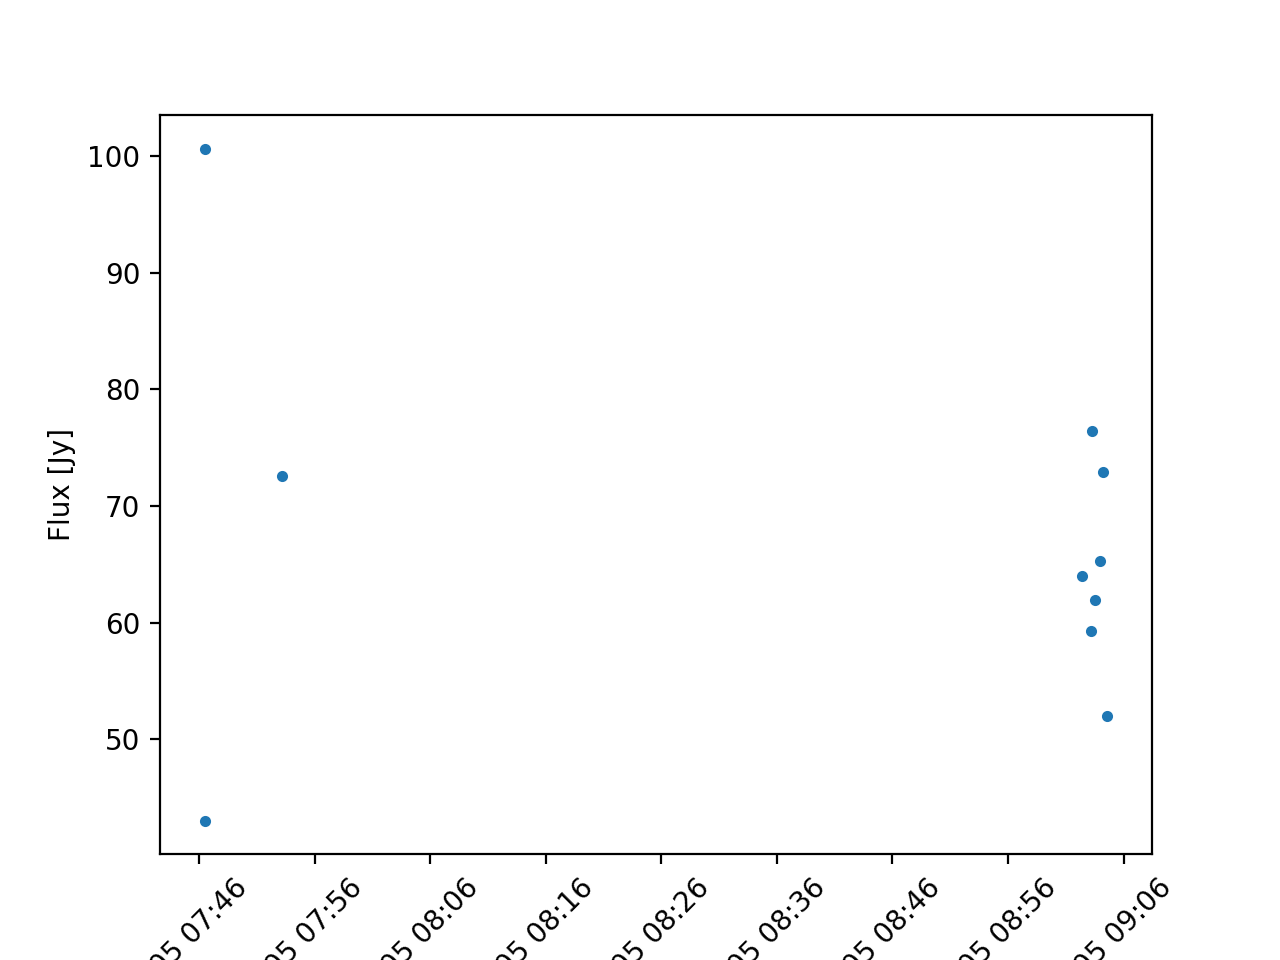

Text(0.5,0,'Day, time ')

In [62]:
import matplotlib.pyplot as plt

%matplotlib notebook 
plt.clf()

plt.show()
plt.plot(pd.to_datetime(su_gps.time), su_gps.f_int, ".")

plt.xticks(rotation = 45)
plt.ylabel("Flux [Jy]")
plt.xlabel("Day, time ")

In [101]:
datetime.strftime(t.datetime, format="%Y-%m-%dT%H:%M:%S")


'2019-09-07T09:34:51'

In [106]:
fits_list = np.array(glob.glob("/data/20190919/*"))
fits_list = np.append(fits_list, np.array(glob.glob("/data/20190920/*")))


In [107]:
len(fits_list)

18034

In [8]:
all_GW = [
    "S190408an",
    "S190930t",
    "S190930s",
"S190924h",
"S190923y",
"S190915ak",
"S190910h",
"S190910d",
"S190901ap",
"S190829u",
'S190828l',
'S190828j',
'S190816i',
'S190814bv',
'S190728q',
'S190727h',
'S190720a',
'S190718y',
'S190707q',
'S190706ai',
'S190701ah',
'S190630ag',
'S190602aq',
'S190521r',
'S190521g',
'S190519bj',
'S190517h',
'S190513bm',
'S190512at',
'S190510g',
'S190503bf',
'S190426c',
'S190425z',
'S190421ar',
'S190412m',
'S190408an'
]




